In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import time

# Load the data

In [3]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

print(len(cars))

t=time.time()
X=[]
for car in cars:
    image = cv2.imread(car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X.append(image)
for non_car in non_cars:
    image = cv2.imread(non_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X.append(image)
X = np.array(X)
print(len(X))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to load the data...')

8792
17760
3.09 Seconds to load the data...


In [4]:
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])
print(Y)
print(len(Y))

[ 1.  1.  1. ...,  0.  0.  0.]
17760


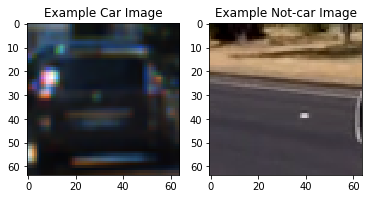

In [5]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(X[1])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(X[-1])
plt.title('Example Not-car Image')

# Training and validation set split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


# Train with Keras a convnet classifier model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def convnet(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3',border_mode="same"))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv5',border_mode="same"))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv6',border_mode="same"))
    #model.add(Convolution2D(256, 3, 3, activation='relu', name='conv7',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(256,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.2))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = convnet()
model.add(Flatten()) # (None, 1, 1, 1) -> (None, 1)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 128)       147584    
__________

/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(64, 64, 3..., name="conv1", activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv2", activation="relu", padding="same")`
  if sys.path[0] == '':
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv3", activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv4", activation="relu", padding="same")`
  app.launch_new_instance()
/home/phw/.local/lib

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

PATIENCE = 3

#filepath="model.epoch{epoch:02d}-valloss{val_loss:.4f}.h5"
#checkpoint = ModelCheckpoint(filepath, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)

t=time.time()
history_object = model.fit(X_train, Y_train, batch_size=128, nb_epoch=30, verbose=1, validation_data=(X_test, Y_test), callbacks = [early_stopping])
t2=time.time()
print(round(t2-t, 2), 'Seconds to train the model...')

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("convnet.h5")


/home/phw/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15984 samples, validate on 1776 samples
Epoch 1/30
15984/15984 [==============================] - 17s 1ms/step - loss: 0.0850 - acc: 0.8857 - val_loss: 0.0421 - val_acc: 0.9443
Epoch 2/30
15984/15984 [==============================] - 14s 880us/step - loss: 0.0270 - acc: 0.9652 - val_loss: 0.0216 - val_acc: 0.9735
Epoch 3/30
15984/15984 [==============================] - 15s 909us/step - loss: 0.0190 - acc: 0.9762 - val_loss: 0.0114 - val_acc: 0.9854
Epoch 4/30
15984/15984 [==============================] - 15s 909us/step - loss: 0.0132 - acc: 0.9835 - val_loss: 0.0101 - val_acc: 0.9859
Epoch 5/30
15984/15984 [==============================] - 15s 909us/step - loss: 0.0087 - acc: 0.9891 - val_loss: 0.0048 - val_acc: 0.9961
Epoch 6/30
15984/15984 [==============================] - 15s 910us/step - loss: 0.0066 - acc: 0.9918 - val_loss: 0.0051 - val_acc: 0.9910
Epoch 7/30
15984/15984 [==============================] - 15s 911us/step - loss: 0.0060 - acc: 0.9925 - val_loss: 0.005

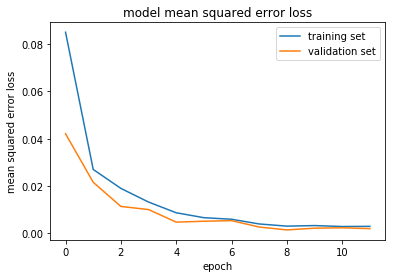

In [9]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('history.png')
plt.show()

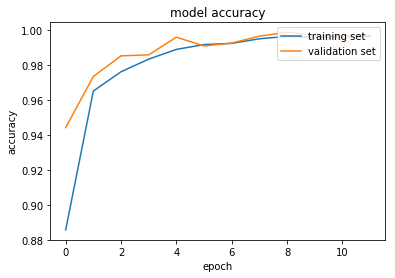

In [10]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('history.png')
plt.show()

In [11]:
ls

convnet.h5        P5.ipynb                vehicles/
examples/         project_video.mp4       vehicles.zip
history.png       project_video_out1.mp4  writeup/
__MACOSX/         README.md               writeup_philippew.md
non-vehicles/     test_images/            writeup_template.md
non-vehicles.zip  test_video.mp4
output_images/    test_video_out1.mp4


# Create pipeline

In [12]:
HOTMAP_THRES =  0.9999999 #0.99
#HOTMAP_THRES = 0.999999 #0.99
MH = 64
MW = 64
CROP_YMIN = 400
CROP_YMAX = 660
N_FRAMES_FILTER = 1 # 1 # 3 # 3

SCALE0 = 0.5 # 0.5
SCALE1 = 1.2 # 1.2
SCALE1 = 0.7
SCALE2 = 1.8 # 1.8 #1.8

DEBUG = 1

In [13]:
heatmodel = convnet(input_shape=(None, None, 3), filename="convnet.h5")
heatmodel.summary()

/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(None, Non..., name="conv1", activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv2", activation="relu", padding="same")`
  if sys.path[0] == '':
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv3", activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/home/phw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv4", activation="relu", padding="same")`
  app.launch_new_instance()
/home/phw/.local/lib

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 64)    1792      
_________________________________________________________________
conv2 (Conv2D)               (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv3 (Conv2D)               (None, None, None, 128)   73856     
_________________________________________________________________
conv4 (Conv2D)               (None, None, None, 128)   147584    
__________

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [15]:
def find_boxes_front(hotmap, boxes, scale, crop_ymin=0, crop_xmin=0):
    # This finds us boxes around detected cars
    xx, yy = np.meshgrid(np.arange(hotmap.shape[2]), np.arange(hotmap.shape[1]))
    x = (xx[hotmap[0,:,:,0] > HOTMAP_THRES])
    y = (yy[hotmap[0,:,:,0] > HOTMAP_THRES])
    
    # We save those rects in a list
    mw = int(scale * MW)
    mh = int(scale * MH)
    for i,j in zip(x,y):
        mx = int(scale*(i*8))+crop_xmin
        my = int(scale*(j*8))+crop_ymin
        boxes.append((mx, my, mw, mh))

def find_boxes(hotmap, boxes, scale, crop_ymin=0, crop_xmin=0):
    # This finds us boxes around detected cars
    xx, yy = np.meshgrid(np.arange(hotmap.shape[2]), np.arange(hotmap.shape[1]))
    x = (xx[hotmap[0,:,:,0] > HOTMAP_THRES])
    y = (yy[hotmap[0,:,:,0] > HOTMAP_THRES])
    
    # We save those rects in a list
    mw = int(scale * MW)
    mh = int(scale * MH)
    for i,j in zip(x,y):
        mx = int(scale*(i*8))+crop_xmin
        my = int(scale*(j*8))+crop_ymin
        # XXX boxes.append(((mx, my), (mx+mw, my+mh)))
        if DEBUG == 1:
            boxes.append((mx, my, mw, mh))
        else:
            boxes.append(((mx, my), (mx+mw, my+mh)))


In [16]:
import collections
heatmaps = collections.deque(maxlen=N_FRAMES_FILTER)


In [39]:
from scipy.ndimage.measurements import label

def process_image(img):
    orig_img = img.copy()
    # We crop the image to 400-660px in the vertical direction from 720x1280
    #crop_img = orig_img[CROP_YMIN:CROP_YMAX, :] # TODO MAKE THAT DYNAMIC based on img.shape
        
    boxes = []
    
    
    scales = [0.7, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0]
    #scales = [1.0]
    for scale in scales:
        #crop_img = orig_img[CROP_YMIN:550, 400::] # 150 -> 250
        crop_img = orig_img
        dimx = int(crop_img.shape[0]/scale)
        dimy = int(crop_img.shape[1]/scale)
        resized_img = cv2.resize(crop_img, (dimy, dimx), interpolation=cv2.INTER_AREA)
        hotmap1 = heatmodel.predict(resized_img.reshape(1, resized_img.shape[0], resized_img.shape[1], resized_img.shape[2]))
        #find_boxes(hotmap1, boxes, scale=SCALE1, crop_ymin=CROP_YMIN, crop_xmin=400) # 150 -> 250
        find_boxes(hotmap1, boxes, scale=scale)
    
    # XXX PWE TEMP
    if DEBUG == 1:
        for (mx,my,mw,mh) in boxes:
            cv2.rectangle(orig_img, (mx, my), (mx+mw, my+mh), (0,0,255), 5)
        return orig_img

    heat = np.zeros_like(orig_img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    heatmaps.append(heat)
    heatmaps_sum = sum(heatmaps)
    
    # Apply threshold to help remove false positives
    #heatmaps_sum = apply_threshold(heatmaps_sum, N_FRAMES_FILTER*2) #*3

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmaps_sum, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(orig_img, labels)
    
    return draw_img


0.58 Seconds to process an image...


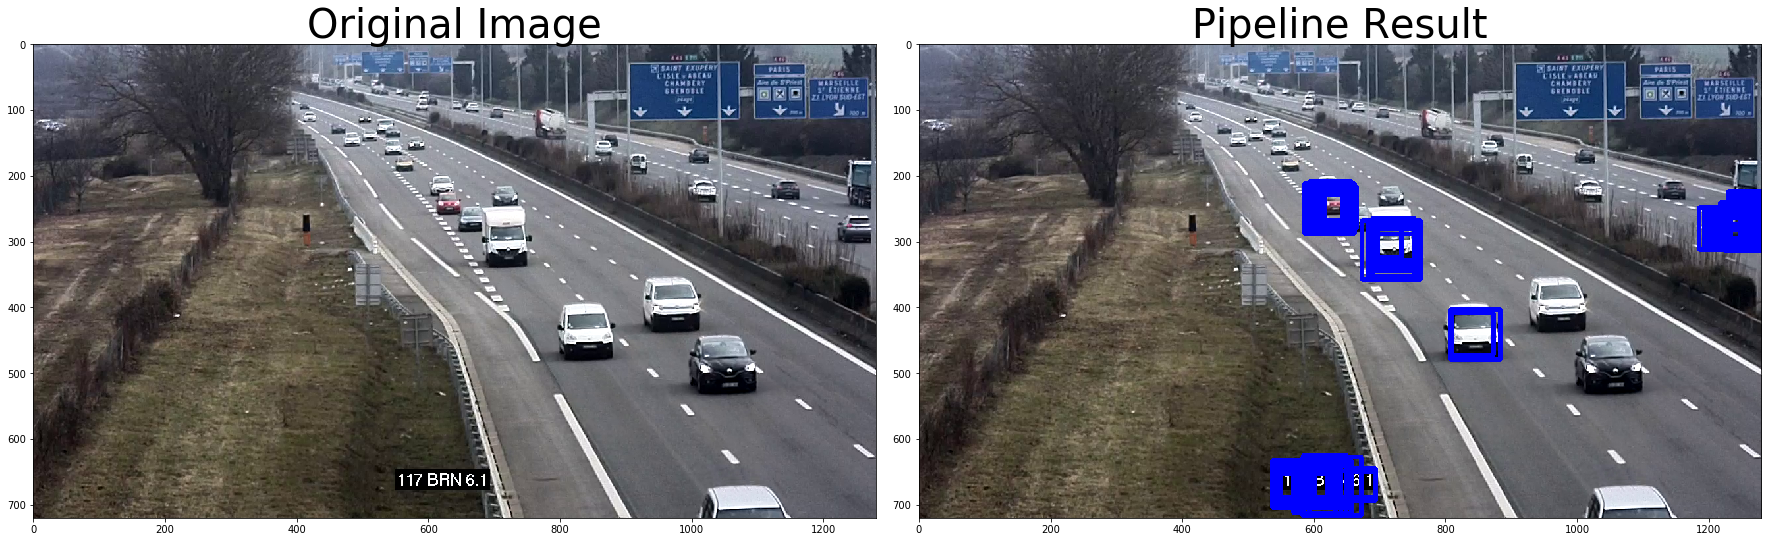

In [43]:
heatmaps.clear()

image = cv2.imread('test_images/image10.png')
original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

t=time.time()
result = process_image(original)
t2=time.time()
print(round(t2-t, 2), 'Seconds to process an image...')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(original)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

1.31 Seconds to process an image...


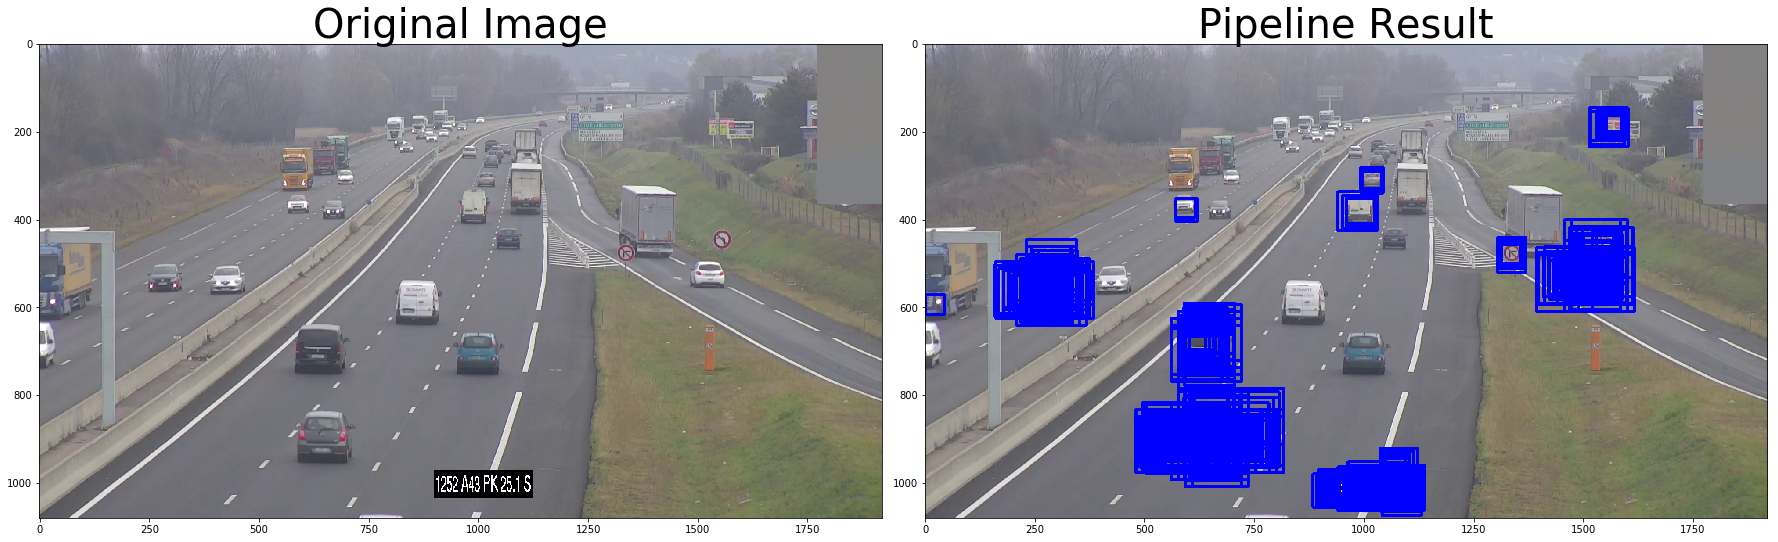

In [42]:
heatmaps.clear()

image = cv2.imread('test_images/image6.png')
original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

t=time.time()
result = process_image(original)
t2=time.time()
print(round(t2-t, 2), 'Seconds to process an image...')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(original)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# test case
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    heatmaps.clear()
    image = cv2.imread(fname)
    original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_image(original)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)

# Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
ls

In [ ]:
heatmaps.clear()
output = 'test_video_out1.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(output, audio=False)

In [ ]:
heatmaps.clear()
output = 'project_video_out1.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0.2,51)
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(output, audio=False)

# Debug area

In [ ]:
THRESHOLD = 0.99

In [ ]:
heatmodel = convnet(input_shape=(None, None, 3), filename="convnet.h5")

In [ ]:
heatmodel.summary()

In [ ]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

heatmap = heatmodel.predict(image.reshape(1, image.shape[0], image.shape[1], image.shape[2]))
print(image.shape)
print(heatmap.shape)

In [ ]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(heatmap[0,:,:,0])
ax2.set_title('Heatmap Image', fontsize=30)

In [ ]:
print(heatmap)

In [ ]:
from scipy.ndimage.measurements import label

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels)

In [ ]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(heatmap[0,:,:,0]>THRESHOLD, cmap="gray")
ax2.set_title('Heatmap Image', fontsize=30)

In [ ]:
xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
x = (xx[heatmap[0,:,:,0]>THRESHOLD])
y = (yy[heatmap[0,:,:,0]>THRESHOLD])

In [ ]:
print(xx.shape)
print(yy.shape)

In [ ]:
print(len(x))
print(len(y))

In [ ]:
original_image = image.copy()

In [ ]:
rect = []
for i,j in zip(x,y):
        #print(i*8, j*8)
        mx = i*8
        my = j*8
        print(mx, my)
        if my >= 400 and my <= 620:
            cv2.rectangle(image, (mx, my), (mx+64,my+64), (0,0,255), 5)
            rect.append((mx, my, 64, 64))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(original_image)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Augmented Image', fontsize=30)

#plt.title("Augmented")    
#plt.imshow(image)
#plt.show()

In [ ]:
print(rect)

In [ ]:
thresh=1
#rect1 , w1 = cv2.groupRectangles(list(rect), thresh)
#rect1 , w1 = cv2.groupRectangles(list(rect), thresh, 0.1)
rect1 , w1 = cv2.groupRectangles(np.array(rect).tolist(), 6, 0.4)
#np.array(mouth).tolist()
print(rect1)

In [ ]:
print(w1)

In [ ]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for (mx,my,mw,mh) in rect1:
        #print(i*8, j*8)
        cv2.rectangle(image, (mx, my), (mx+mw, my+mh), (0,0,255), 5)

plt.title("Augmented")    
plt.imshow(image)
plt.show()

In [ ]:
print(rect)

In [ ]:
rect1 , w1 = cv2.groupRectangles(np.array(rect).tolist(), 1, 1)


In [ ]:
np.array(rect)[:,0]

In [ ]:
rect2 = non_max_suppression_fast(np.array(rect), 0)
print(len(rect))
print(len(rect2))